# AutoCorrelation

This notebook examines auto-correlation measures applied to simulated neural time series.

This notebook covers:
- autocorrelation
- autocorrelation decay time

In [1]:
# Setup notebook state
from nbutils import setup_notebook; setup_notebook()

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from neurodsp.aperiodic import compute_autocorr
from neurodsp.sim import sim_powerlaw, sim_combined, sim_synaptic_current, sim_knee
from neurodsp.utils import set_random_seed

In [4]:
# Import custom project code
from apm.io import APMDB
from apm.run import run_sims, run_sims_load
from apm.methods import autocorr, autocorr_decay_time
from apm.methods.settings import AC_PARAMS, AC_DECAY_PARAMS
from apm.plts import plot_lines, plot_colorbar
from apm.plts.sims import plot_sims, plot_ap_sims, plot_pe_sims
from apm.plts.utils import truncate_colormap, figsaver
from apm.plts.settings import COLORS
from apm.sim.examples import get_examples
from apm.sim.settings import N_SIMS
from apm.sim.defs import SIM_ITERS
from apm.utils.data import min_n_max

## Settings

In [5]:
# Get current sampling rate
fs = SIM_ITERS.fs

In [6]:
# Add sampling rate to settings
AC_DECAY_PARAMS['fs'] = fs

In [7]:
# # Set custom max lag time for autocorrelation
# AC_PARAMS['max_lag'] = 125

In [8]:
# Custom settings for autocorrelation - downsample frequencies and powers
FREQS2 = np.arange(5., 40, 10)
POWERS2 = np.round(np.arange(0, 2.5, 0.5), 1)

In [9]:
# Update values in iterators
SIM_ITERS.update_iter('osc_freq', 'values', FREQS2)
SIM_ITERS.update_iter('osc_pow', 'values', [[1, val] for val in POWERS2])

In [10]:
# Check auto-correlation parameters
print(AC_PARAMS)
print(AC_DECAY_PARAMS)

{'max_lag': 250, 'lag_step': 1}
{'fs': 250, 'max_lag': 1500, 'lag_step': 2, 'level': 0.5}


In [11]:
# Define expected size of the autocorrelation result
OUTSIZE = int(AC_PARAMS['max_lag'] / AC_PARAMS['lag_step'] + 1)

In [12]:
# Set the colormap for the plots
cmap_name = 'BuGn_r'
cmap_range = (0., 0.75)

# Get the requested colormap & range
cmap = truncate_colormap(plt.get_cmap(cmap_name), *cmap_range)

# Set up the colors for plotting
exp_colors = cmap(np.linspace(0., 1.0, len(SIM_ITERS['ap_exp'].values)))
freq_colors = cmap(np.linspace(0., 1.0, len(FREQS2)))
power_colors = cmap(np.linspace(0., 1.0, len(POWERS2)))

In [13]:
# Plot settings
PLT_KWARGS = {
    'xlabel' : 'Time (s)',
    'ylabel' : 'Autocorrelation',
}

In [14]:
# Settings for saving figures
SAVE_FIG = True
FIGPATH = APMDB().figs_path / '21_autocorr'

# Create helper function to manage figsaver settings
fsaver = figsaver(SAVE_FIG, FIGPATH)

In [15]:
# Set the random seed
set_random_seed(111)

In [16]:
# Define collection of example signals
examples = get_examples()

## AutoCorrelation Measures

The autocorrelation of a signal is measured as the correlation between a signal, and a time-lagged copy of itself. This is typically computed a range of different time lags.

The autocorrelation decay time is a measure of how quickly the autocorrelation decays to a given value - for example, at what timelag the autocorrelation first crosses below zero.

### Measures on Example Signals

First, we will calculate the autocorrelation across different example signals.

### Powerlaw Signals

In [17]:
# Calculate autocorrelation
times, sig_ap_ac = compute_autocorr(examples['powerlaw'], **AC_PARAMS)

In [18]:
# Compute decay rate time
ap_decay = autocorr_decay_time(examples['powerlaw'], **AC_DECAY_PARAMS)
ap_decay

0.016

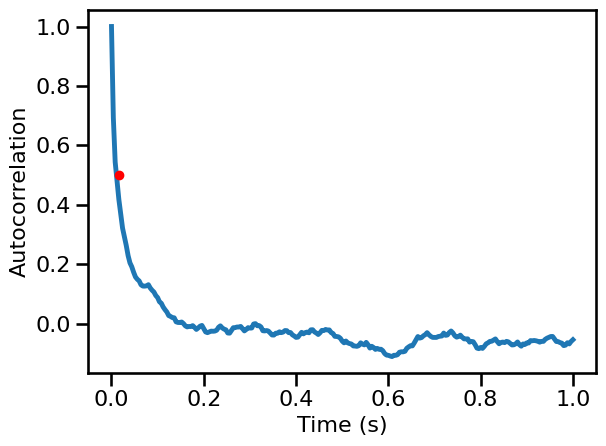

In [19]:
# Plot the autocorrelation across time delays
plot_lines(times / fs, sig_ap_ac, **PLT_KWARGS, **fsaver('ac_ap'))
plt.gca().plot(ap_decay, AC_DECAY_PARAMS['level'], '.', ms=12, color='red')

### Oscillatory Signal

In [20]:
# Calculate autocorrelation
times, sig_osc_ac = compute_autocorr(examples['oscillation'], **AC_PARAMS)

In [21]:
# Compute decay rate time
osc_decay = autocorr_decay_time(examples['oscillation'], **AC_DECAY_PARAMS)
osc_decay

0.024

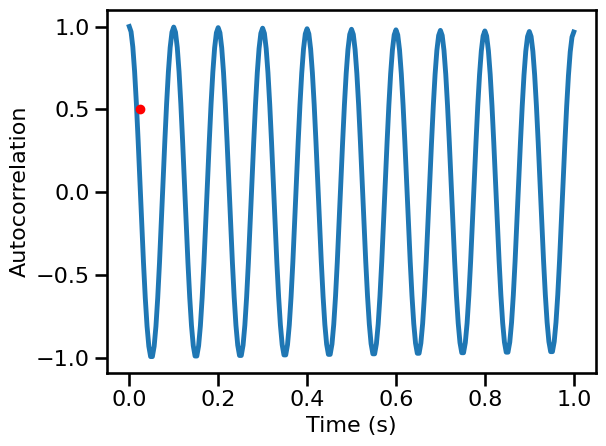

In [22]:
# Plot the autocorrelation across time delays
plot_lines(times / fs, sig_osc_ac, **PLT_KWARGS, **fsaver('ac_osc'))
plt.gca().plot(osc_decay, AC_DECAY_PARAMS['level'], '.', ms=12, color='red')

### Combined Signal

In [23]:
# Calculate autocorrelation
times, sig_comb_ac = compute_autocorr(examples['combined'], **AC_PARAMS)

In [24]:
# Compute decay rate time
comb_decay = autocorr_decay_time(examples['combined'], **AC_DECAY_PARAMS)
comb_decay

0.016

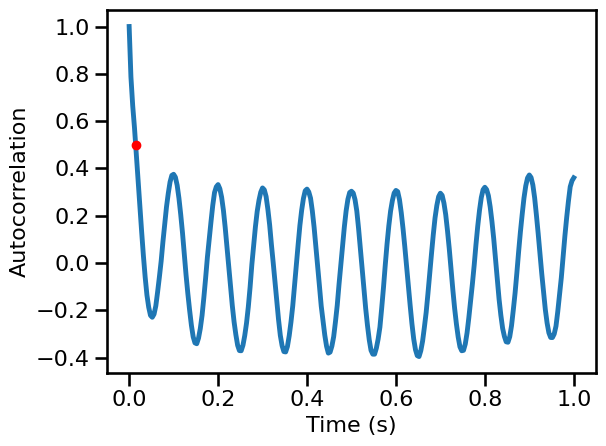

In [25]:
# Plot the autocorrelation across time delays
plot_lines(times / fs, sig_comb_ac, **PLT_KWARGS, **fsaver('ac_comb'))
plt.gca().plot(comb_decay, AC_DECAY_PARAMS['level'], '.', ms=12, color='red')

### Synaptic Activity Model

In [26]:
# Calculate autocorrelation
times, sig_syn_ac = compute_autocorr(examples['synaptic'], **AC_PARAMS)

In [27]:
# Compute decay rate time
syn_decay = autocorr_decay_time(examples['synaptic'], **AC_DECAY_PARAMS)
syn_decay

0.008

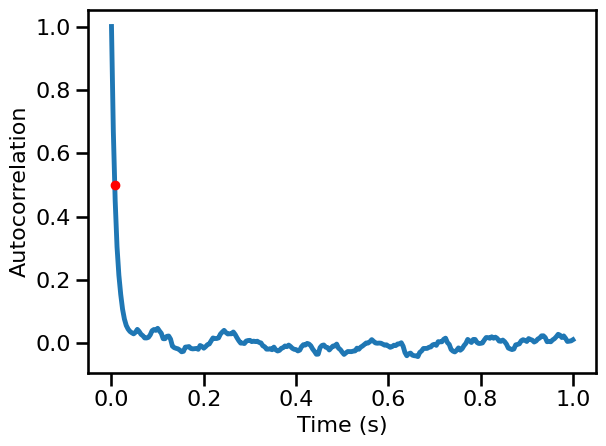

In [28]:
# Plot the autocorrelation across time delays
plot_lines(times / fs, sig_syn_ac, **PLT_KWARGS, **fsaver('ac_syn'))
plt.gca().plot(syn_decay, AC_DECAY_PARAMS['level'], '.', ms=12, color='red')

### Powerlaw Signals with a Knee

In [29]:
# Calculate autocorrelation
times, sig_kn_ac = compute_autocorr(examples['knee'], **AC_PARAMS)

In [30]:
# Compute decay rate time
kn_decay = autocorr_decay_time(examples['knee'], **AC_DECAY_PARAMS)
kn_decay

0.016

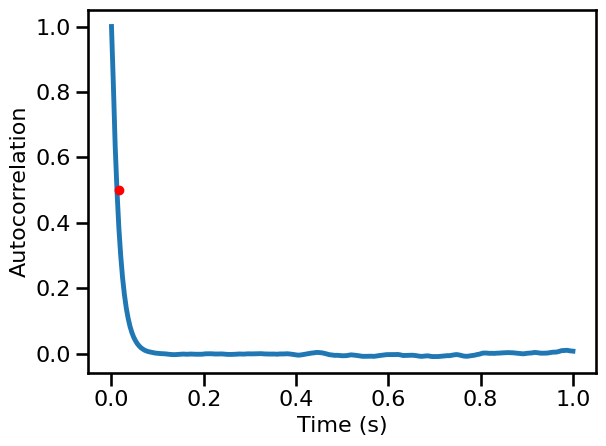

In [31]:
# Plot the autocorrelation across time delays
plot_lines(times / fs, sig_kn_ac, **PLT_KWARGS, **fsaver('ac_knee'))
plt.gca().plot(kn_decay, AC_DECAY_PARAMS['level'], '.', ms=12, color='red')

### Bandwidth

In [32]:
# Calculate autocorrelation
times, sig_bw_ac = compute_autocorr(examples['comb_peak'], **AC_PARAMS)

In [33]:
# Compute decay rate time
bw_decay = autocorr_decay_time(examples['comb_peak'], **AC_DECAY_PARAMS)
bw_decay

0.016

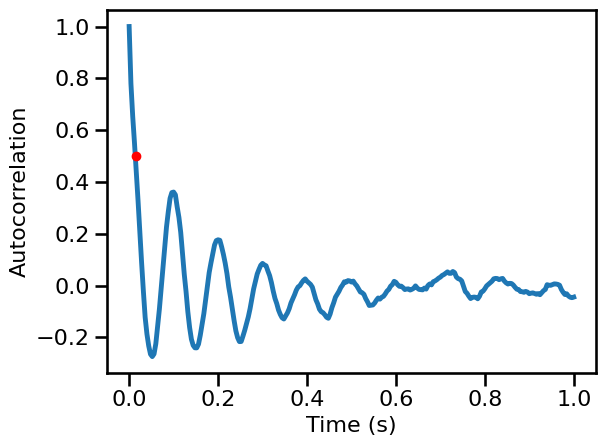

In [34]:
# Plot the autocorrelation across time delays
plot_lines(times / fs, sig_bw_ac, **PLT_KWARGS, **fsaver('ac_bw'))
plt.gca().plot(bw_decay, AC_DECAY_PARAMS['level'], '.', ms=12, color='red')

### Burst

In [35]:
# Calculate autocorrelation
times, sig_burst_ac = compute_autocorr(examples['comb_burst'], **AC_PARAMS)

In [36]:
# Compute decay rate time
burst_decay = autocorr_decay_time(examples['comb_burst'], **AC_DECAY_PARAMS)
burst_decay

0.016

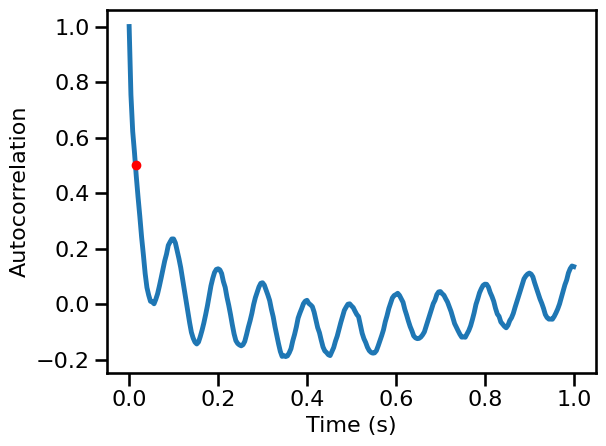

In [37]:
# Plot the autocorrelation across time delays
plot_lines(times / fs, sig_burst_ac, **PLT_KWARGS, **fsaver('ac_burst'))
plt.gca().plot(burst_decay, AC_DECAY_PARAMS['level'], '.', ms=12, color='red')

## AutoCorrelation Simulations: Aperiodic Variations

### Powerlaw Signals

In [38]:
# Run a set of simulations, calculating autocorrelation across exponents
ac_sims_exp = run_sims(sim_powerlaw, SIM_ITERS['ap_exp'],
                       autocorr, AC_PARAMS, N_SIMS, outsize=OUTSIZE)

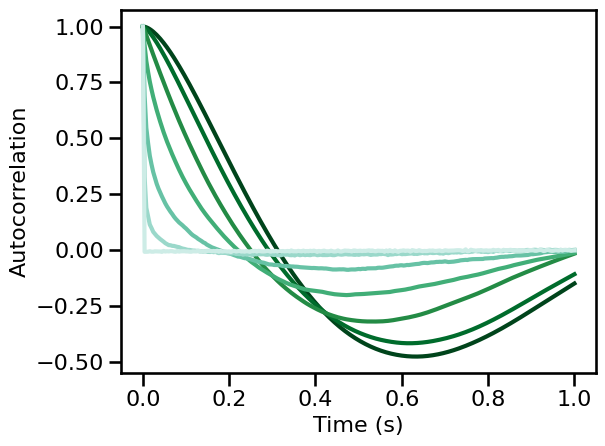

In [39]:
# Plot autocorrelation across exponent values
for ac, color in zip(np.mean(ac_sims_exp, 1), exp_colors):
    plot_lines(times / fs, ac, color=color, lw=3)
plot_lines(**PLT_KWARGS, **fsaver('ac_exp'))

In [40]:
# Run a set of simulations, calculating autocorrelation across exponents
decay_sims_exp = run_sims(sim_powerlaw, SIM_ITERS['ap_exp'],
                          autocorr_decay_time, AC_DECAY_PARAMS, N_SIMS)

### Combined Signals

In [41]:
# Run a set of simulations, calculating autocorrelation across exponents, with an oscillation
ac_sims_comb = run_sims(sim_combined, SIM_ITERS['comb_exp'],
                        autocorr, AC_PARAMS, N_SIMS, outsize=OUTSIZE)

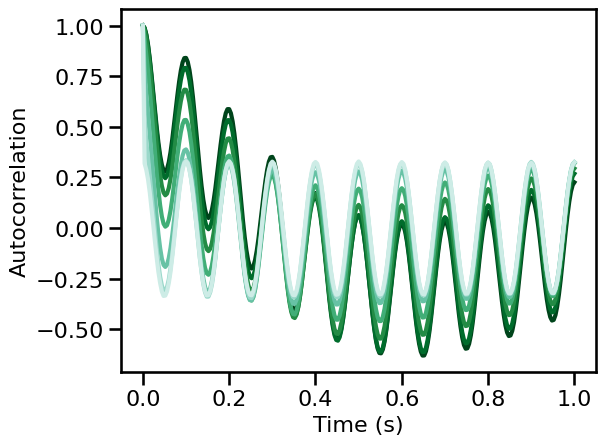

In [42]:
# Plot autocorrelation across exponent values
for ac, color in zip(np.mean(ac_sims_comb, 1), exp_colors):
    plot_lines(times / fs, ac, color=color, lw=3)
plot_lines(**PLT_KWARGS, **fsaver('ac_comb'))

In [43]:
# Run a set of simulations, calculating autocorrelation across exponents
decay_sims_comb = run_sims(sim_combined, SIM_ITERS['comb_exp'],
                           autocorr_decay_time, AC_DECAY_PARAMS, N_SIMS)

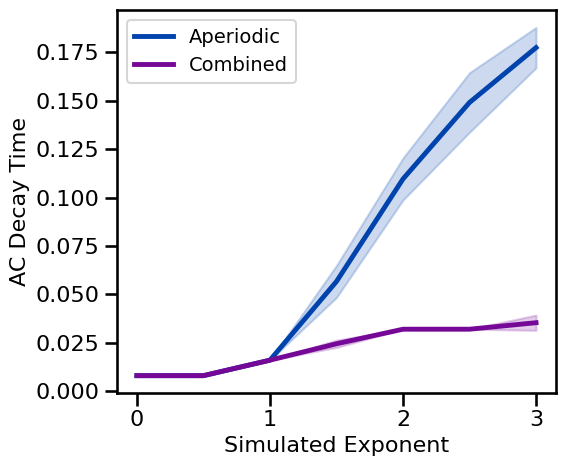

In [44]:
# Plot AC decay rate estimates across aperiodic variations
plot_ap_sims(decay_sims_exp, decay_sims_comb, 'AC Decay Time', **fsaver('ac_decay_ap'))

## AutoCorrelation Simulations: Periodic Variations

### Oscillation Frequency

In [45]:
# Run a set of simulations, calculating autocorrelations across oscillation frequency
ac_sims_freq = run_sims(sim_combined, SIM_ITERS['osc_freq'],
                        autocorr, AC_PARAMS, N_SIMS, outsize=OUTSIZE)

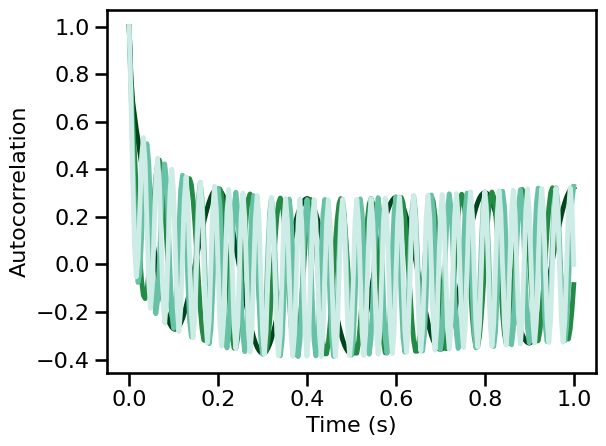

In [46]:
# Plot autocorrelation across oscillation frequency
for ac, color in zip(np.mean(ac_sims_freq, 1), freq_colors):
    plot_lines(times / fs, ac, color=color)
plot_lines(**PLT_KWARGS, **fsaver('ac_osc_freq'))

In [47]:
# Run a set of simulations, calculating autocorrelation across oscillation frequency
decay_sims_freq = run_sims(sim_combined, SIM_ITERS['osc_freq'],
                           autocorr_decay_time, AC_DECAY_PARAMS, N_SIMS)

### Oscillation Power

In [48]:
# Run a set of simulations, calculating autocorrelations across oscillation power
ac_sims_pow = run_sims(sim_combined, SIM_ITERS['osc_pow'],
                       autocorr, AC_PARAMS, N_SIMS, outsize=OUTSIZE)

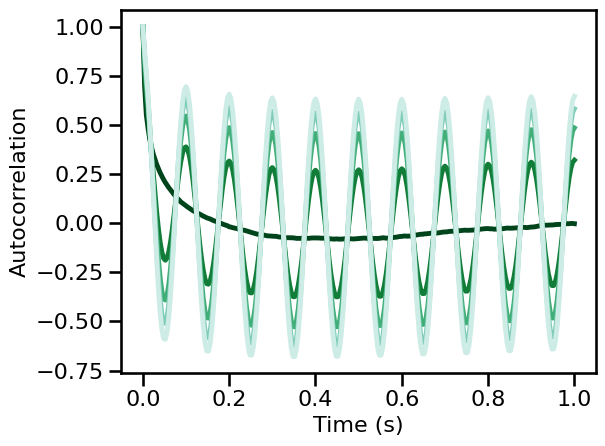

In [49]:
# Plot autocorrelation across oscillation power
for ac, color in zip(np.mean(ac_sims_pow, 1), power_colors):
    plot_lines(times / fs, ac, color=color)
plot_lines(**PLT_KWARGS, **fsaver('ac_osc_pow'))

In [50]:
# Run a set of simulations, calculating autocorrelation across oscillation power
decay_sims_pow = run_sims(sim_combined, SIM_ITERS['osc_pow'],
                          autocorr_decay_time, AC_DECAY_PARAMS, N_SIMS)

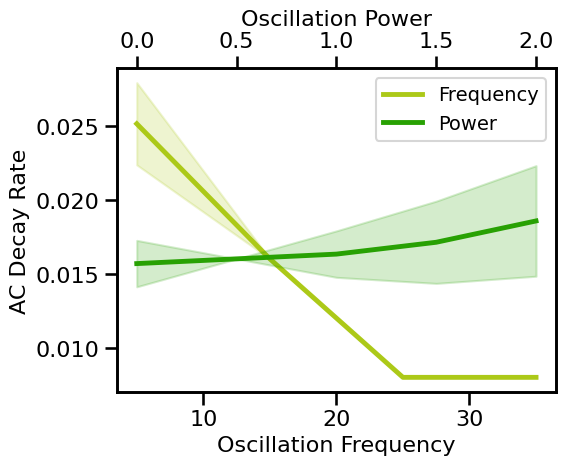

In [51]:
# Plot AC decay rate estimates across periodic variations
plot_pe_sims(decay_sims_freq, decay_sims_pow, 'AC Decay Rate',
             x_freqs=FREQS2, x_pows=POWERS2, **fsaver('ac_decay_pe'))

## Simulations: Synaptic Model Time Constants

In [52]:
# Run a set of simulations, calculating autocorrelations across synaptic timescales
ac_sims_tscales = run_sims(sim_synaptic_current, SIM_ITERS['syn_tscales'],
                           autocorr, AC_PARAMS, N_SIMS, outsize=OUTSIZE)

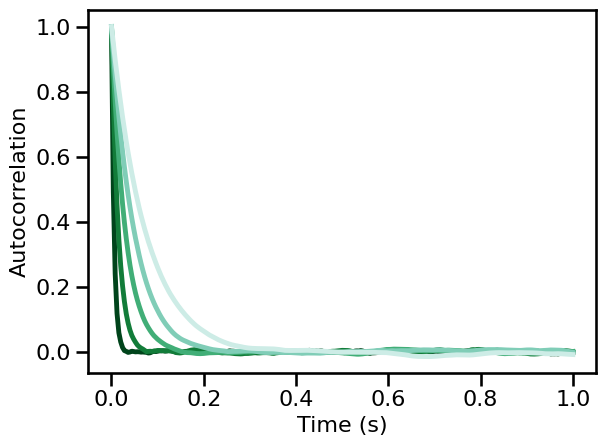

In [53]:
# Plot autocorrelation across synaptic timescale values
for ac, color in zip(np.mean(ac_sims_tscales, 1), power_colors):
    plot_lines(times / fs, ac, color=color)
plot_lines(**PLT_KWARGS, **fsaver('ac_osc_tscale'))

In [54]:
# Run a set of simulations, calculating autocorrelation decay across synaptic timescales
decay_sims_tscales = run_sims(sim_synaptic_current, SIM_ITERS['syn_tscales'],
                              autocorr_decay_time, AC_DECAY_PARAMS, N_SIMS)

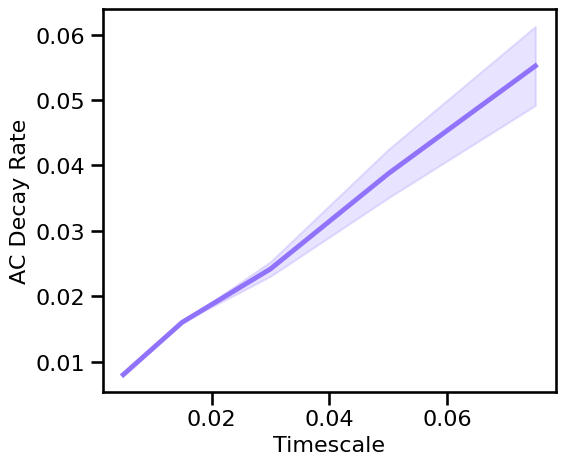

In [55]:
# Plot the estimated AC decay rate across different timescales
plot_sims(SIM_ITERS['syn_tscales'].values, decay_sims_tscales, 'Timescale',
          'AC Decay Rate', COLORS['KN'], **fsaver('ac_decay_tscale'))

## Simulations: Knee Variations

In [56]:
# Run a set of simulations, calculating autocorrelations across knee values
ac_sims_knee = run_sims(sim_knee, SIM_ITERS['kn_knee'],
                        autocorr, AC_PARAMS, N_SIMS, outsize=OUTSIZE)

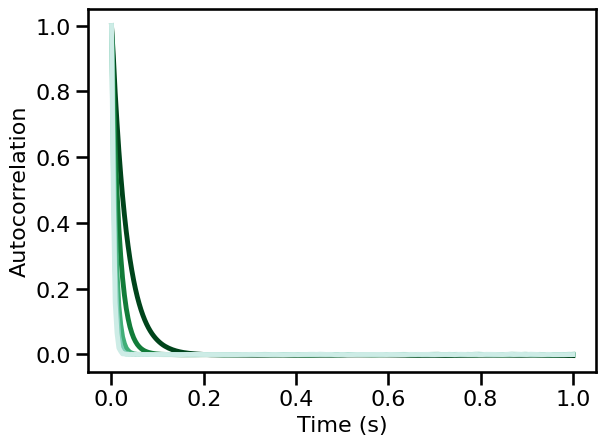

In [57]:
# Plot autocorrelation across knee values
for ac, color in zip(np.mean(ac_sims_knee, 1), power_colors):
    plot_lines(times / fs, ac, color=color)
plot_lines(**PLT_KWARGS, **fsaver('ac_osc_kn'))

In [58]:
# Run a set of simulations, calculating autocorrelation decay across knee values
decay_sims_knee = run_sims(sim_knee, SIM_ITERS['kn_knee'],
                           autocorr_decay_time, AC_DECAY_PARAMS, N_SIMS)

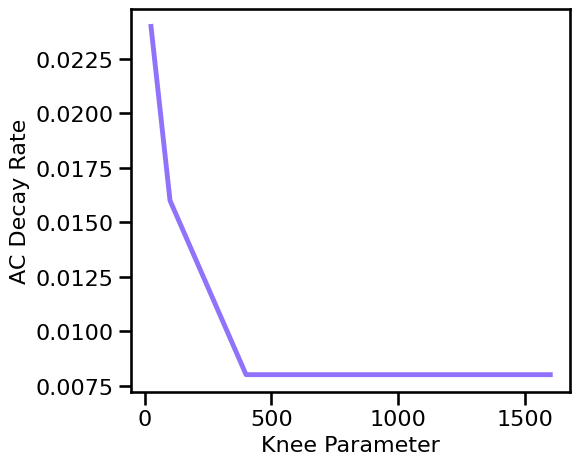

In [59]:
# Plot the estimated AC decay rate across different knee values
plot_sims(SIM_ITERS.iters['kn_knee'].values, decay_sims_knee,
          'Knee Parameter', 'AC Decay Rate', COLORS['KN'], **fsaver('ac_decay_kn'))

## Simulations: Bandwidth Variations

In [60]:
# Run a set of simulations, calculating autocorrelation across peak bandwidth (sims from file)
ac_sims_bw = run_sims_load('comb-bw-' + str(fs), autocorr, AC_PARAMS, outsize=OUTSIZE)

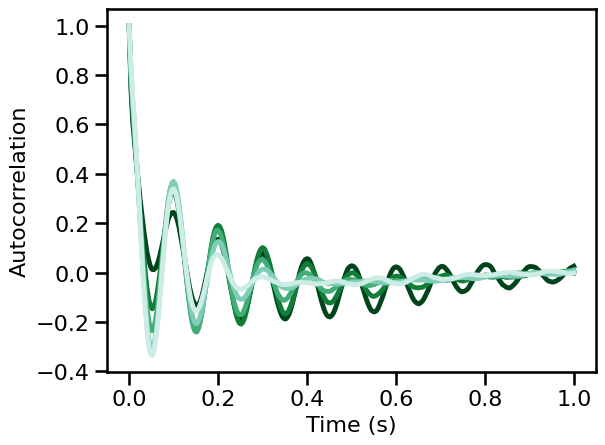

In [61]:
# Plot autocorrelation across oscillation bandwidth
for ac, color in zip(np.mean(ac_sims_bw, 1), power_colors):
    plot_lines(times / fs, ac, color=color)
plot_lines(**PLT_KWARGS, **fsaver('ac_osc_bw'))

In [62]:
# Run a set of simulations, calculating AC decay rate across peak bandwidths
decay_sims_bw = run_sims_load('comb-bw-' + str(fs), autocorr_decay_time, AC_DECAY_PARAMS)

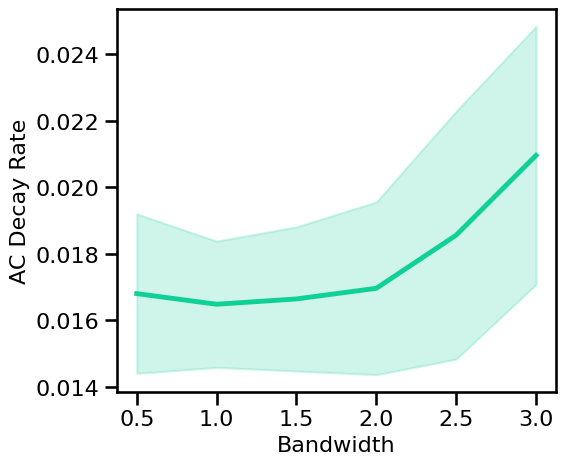

In [63]:
# Plot the estimated AC decay across peak bandwidth
plot_sims(SIM_ITERS['peak_bw'].values, decay_sims_bw, 'Bandwidth',
          'AC Decay Rate', COLORS['BW'], **fsaver('ac_decay_bw'))

## Simulations: Burst Probability

In [64]:
# Run a set of simulations, calculating autocorrelation across burst probability
ac_sims_burst = run_sims(sim_combined, SIM_ITERS['comb_burst'],
                         autocorr, AC_PARAMS, N_SIMS, outsize=OUTSIZE)

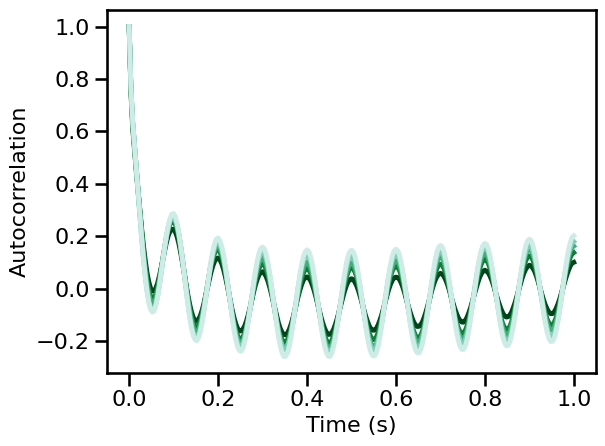

In [65]:
# Plot autocorrelation across oscillation burst probability
for ac, color in zip(np.mean(ac_sims_burst, 1), power_colors):
    plot_lines(times / fs, ac, color=color)
plot_lines(**PLT_KWARGS, **fsaver('ac_osc_burst'))

In [66]:
# Run a set of simulations, calculating autocorrelation decay across knee values
decay_sims_burst = run_sims(sim_combined, SIM_ITERS['comb_burst'],
                            autocorr_decay_time, AC_DECAY_PARAMS, N_SIMS)

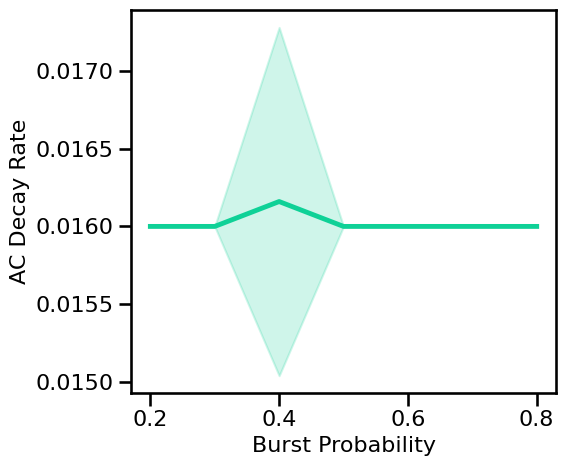

In [67]:
# Plot the estimated AC decay across peak bandwidth
plot_sims(SIM_ITERS['comb_burst'].values, decay_sims_burst, 'Burst Probability',
          'AC Decay Rate', COLORS['BW'], **fsaver('ac_decay_bw'))

### Create colorbars for the plots

In [68]:
# Make colorbars for the plots
plot_colorbar(cmap.reversed(), *min_n_max(SIM_ITERS['ap_exp'].values),
              'exponent', close=True, **fsaver('cbar_ac_exp'))
plot_colorbar(cmap.reversed(), *min_n_max(SIM_ITERS['osc_freq'].values),
              'frequency', close=True, **fsaver('cbar_ac_freq'))
plot_colorbar(cmap.reversed(), *min_n_max(POWERS2), 'power',
              close=True, **fsaver('cbar_ac_pow'))
plot_colorbar(cmap.reversed(), *min_n_max(SIM_ITERS['syn_tscales'].values),
              'timescales', close=True, **fsaver('cbar_ac_tscale'))
plot_colorbar(cmap.reversed(), *min_n_max(SIM_ITERS['kn_knee'].values),
              'knee', close=True, **fsaver('cbar_ac_knee'))
plot_colorbar(cmap.reversed(), *min_n_max(SIM_ITERS['peak_bw'].values),
              'bw', close=True, **fsaver('cbar_ac_bw'))
plot_colorbar(cmap.reversed(), *min_n_max(SIM_ITERS['comb_burst'].values),
              'burst probability', close=True, **fsaver('cbar_ac_burst'))

## Conclusions

Overall, we can see the following patterns in these simulations:

Autocorrelation:
- The autocorrelation of 1/f signals decreases across increasing time lags
    - The quickness of this decay relates to the 1/f exponent
- The autocorrelation of periodic signals is itself rhythmic
    - The frequency and scale of the autocorrelation relates to oscillatory frequency and power respectively
- The autocorrelation of combined signals exhibits with decreasing + rhythmic properties of each component